In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import numpy as np
import pandas as pd
import squidpy as sq
import os
from sklearn.preprocessing import LabelEncoder
import scprep
from scvi.model import SCVI
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP, GradModel
from torchcfm.utils import plot_trajectories, torch_wrapper
import pandas as pd
import seaborn as sns
from umap import UMAP
import torch.nn as nn
from torchdyn.core import NeuralODE
import seaborn as sns
from scvi.model import SCVI
import scvi
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance
from sklearn.metrics import r2_score

/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
scRNA = ad.read_h5ad("data/combined_stereoSeq.h5ad")
print ("Combined data shape: ", scRNA.shape)

sc.pp.normalize_total(scRNA, target_sum=1e4)
sc.pp.log1p(scRNA)
sc.pp.highly_variable_genes(scRNA, flavor="seurat_v3", n_top_genes=2000)
scRNA = scRNA[:, scRNA.var.highly_variable]
sc.pp.scale(scRNA, max_value=10)
sc.tl.pca(scRNA, svd_solver='arpack')
sc.pp.neighbors(scRNA)
sc.tl.umap(scRNA)

/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Combined data shape:  (28757, 12771)


/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


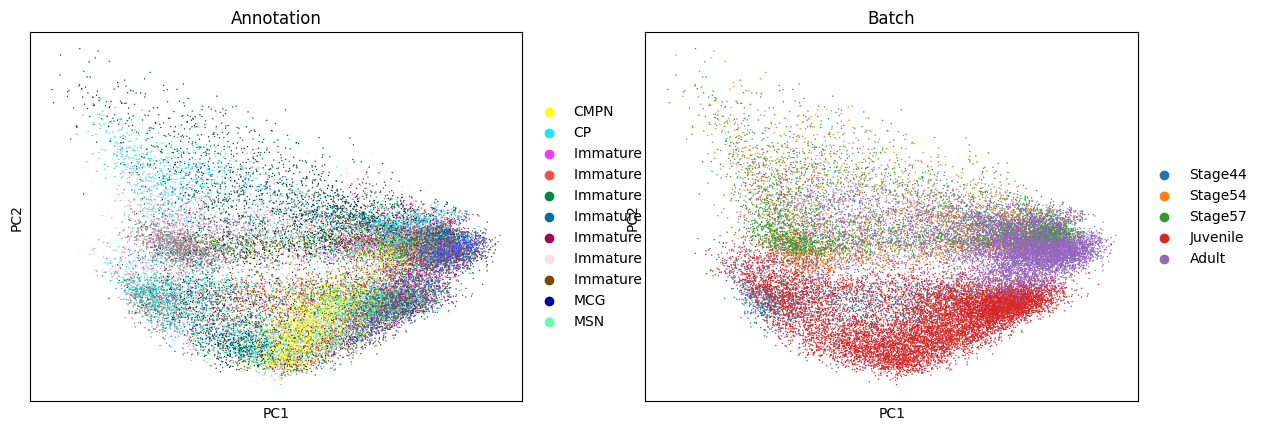

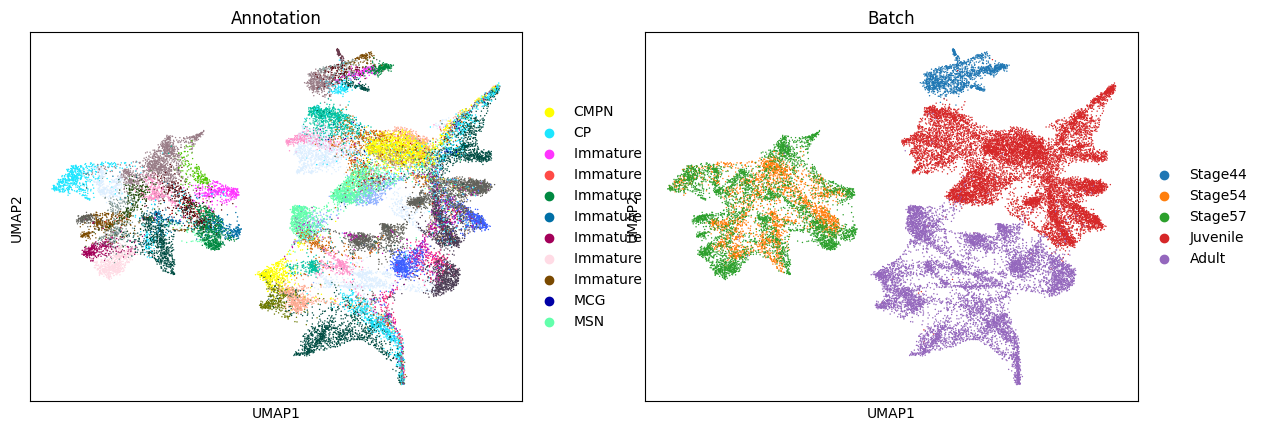

In [3]:
#plot UMAP and PCA
sc.pl.pca(scRNA, color=['Annotation', 'Batch'])
sc.pl.umap(scRNA, color=['Annotation', 'Batch'])

In [4]:
sc.pp.neighbors(scRNA, n_neighbors=15, use_rep='spatial')
print(scRNA.obsp.keys())
print(scRNA.obsm.keys())

KeysView(PairwiseArrays with keys: distances, connectivities)
KeysView(AxisArrays with keys: X_pca, X_umap, spatial)


In [6]:
X = scRNA.X.toarray() if hasattr(scRNA.X, 'toarray') else scRNA.X  # ensure dense [N, G]
A = scRNA.obsp['connectivities']
print ("Initial shape of X: ", X.shape)
print ("Initial shape of A: ", A.shape)

Initial shape of X:  (28757, 2000)
Initial shape of A:  (28757, 28757)


In [12]:
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GATConv
import torch.nn.functional as F

edge_index, edge_weight = from_scipy_sparse_matrix(A)
data = Data(x=torch.tensor(X, dtype=torch.float32), edge_index=edge_index)

class GAT_AE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, heads=2):
        super().__init__()

        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, latent_dim, heads=1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, in_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.gat1(x, edge_index)
        z = F.elu(z)
        z = self.gat2(z, edge_index)
        x_hat = self.decoder(z)
        return z, x_hat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT_AE(in_channels=X.shape[1], hidden_channels=128, latent_dim=64,heads=2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model.train()
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    z, x_hat = model(data)
    loss = F.mse_loss(x_hat, data.x)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z, _ = model(data)
    embedding = z.cpu().numpy()

print("Learned GAT embedding shape:", embedding.shape)
scRNA.obsm['X_gat'] = embedding
print("Stored embedding in scRNA.obsm['X_gat']")

Epoch 0, Loss: 0.9263
Epoch 20, Loss: 0.9034
Epoch 40, Loss: 0.9005
Epoch 60, Loss: 0.8977
Epoch 80, Loss: 0.8918
Epoch 100, Loss: 0.8851
Epoch 120, Loss: 0.8804
Epoch 140, Loss: 0.8762
Epoch 160, Loss: 0.8740
Epoch 180, Loss: 0.8700
Epoch 200, Loss: 0.8669
Epoch 220, Loss: 0.8638
Epoch 240, Loss: 0.8605
Epoch 260, Loss: 0.8583
Epoch 280, Loss: 0.8553
Learned GAT embedding shape: (28757, 64)
Stored embedding in scRNA.obsm['X_gat']


In [15]:
def preprocess_data(scRNA, cell_type_key='Annotation', spatial_key = 'spatial', n_pca=50):

    le = LabelEncoder()
    scRNA.obs[cell_type_key] = le.fit_transform(scRNA.obs[cell_type_key])
    X_input = []
    X_conditional = []
    X_spatial = []

    if (reducer == "UMAP"):
        print ("Using UMAP for input data")
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_umap'])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])
            
    elif (reducer == "PCA"):
        print ("Using PCA for input data")
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_pca'][:, :n_pca])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])

    elif (reducer == "scVI"):
        print ("Using scVI for input data")
        #read the data (again cause scVI requires unormalized data) and set up scVI
        scRNA = ad.read_h5ad("data/combined_stereoSeq.h5ad")
        scvi.model.SCVI.setup_anndata(scRNA)
        model = SCVI(scRNA)
        model.train()
        latent = model.get_latent_representation()
        scRNA.obsm["X_scVI"] = latent
        
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_scVI'])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])

    elif (reducer == "GAT"):
        print ("Using GAT for input data")
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_gat'])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])
    
    else:
        raise ValueError("Unsupported reducer type. Choose from 'UMAP', 'PCA', or 'scVI'.")

    return X_input, X_conditional, X_spatial

reducer = "GAT"
X_input, _, _ = preprocess_data(scRNA)  
n_times = len(X_input)      

Using GAT for input data


In [16]:
params= {}  
params['batch_size'] = 256
params['sigma'] = 0.1
params['dim'] = X_input[0].shape[1]
params['learning_rate'] = 1e-4
params['n_epochs'] = 10000
params['out_dim'] = params['dim']
params['w'] = 64
params['time_varying'] = True
params['lambda_'] = 1

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print ("Using device: ", device)
print ("Input shape: ", X_input[0].shape[1])

Using device:  cuda
Input shape:  64


In [17]:
def get_batch(FM, X_input, batch_size, n_times, return_noise=False):
    """Construct a batch with points from each timepoint pair"""

    ts = []
    xts = []
    uts = []
    np.random.seed(42)
    
    for t_start in range(n_times - 1):
        
        b0 = np.random.randint(X_input[t_start].shape[0], size=batch_size)
        b1 = np.random.randint(X_input[t_start+1].shape[0], size=batch_size)
        
        x0 = (torch.from_numpy(X_input[t_start][b0]).float().to(device))
        x1 = (torch.from_numpy(X_input[t_start + 1][b1]).float().to(device))
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)

    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)

    return t, xt, ut

Using CUDA:  True


100%|██████████| 10000/10000 [09:26<00:00, 17.65it/s]


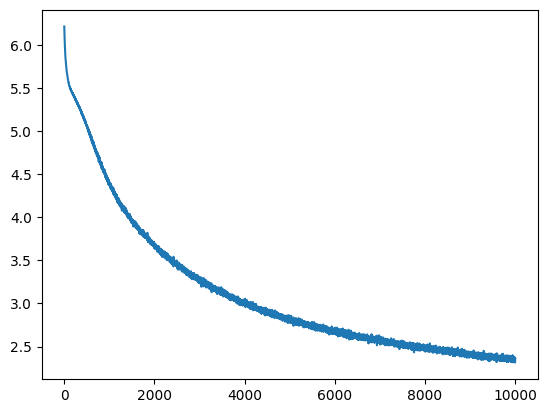

In [18]:
def train(params, n_times, X_input):
    
    use_cuda = torch.cuda.is_available()
    print ("Using CUDA: ", use_cuda)

    batch_size = params['batch_size']

    ot_cfm_model = MLP(dim=params['dim'], out_dim=params['out_dim'], time_varying=params['time_varying'], w=params['w']).to(device)
    ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), params['learning_rate'])
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=params['sigma'])

    losses = []
    for i in tqdm(range(params['n_epochs'])):
        ot_cfm_optimizer.zero_grad()
        t, xt, ut = get_batch(FM, X_input, batch_size, n_times)
        vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))

        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        losses.append(loss.item())
        ot_cfm_optimizer.step()

    plt.plot(losses)

    return ot_cfm_model

ot_cfm_model= train(params, n_times,  X_input)

In [19]:
"""
M = lambda_*torch.cdist(x0, x1) ** 2+ (1-lambda_)*torch.cdist(p0, p1)**2
"""

'\nM = lambda_*torch.cdist(x0, x1) ** 2+ (1-lambda_)*torch.cdist(p0, p1)**2\n'

In [20]:
class SimpleODEVectorField(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, args=None):
        # Expand scalar t to match batch size
        if x.dim() > 1:
            t_expanded = t.expand(x.shape[0], 1) if isinstance(t, torch.Tensor) else torch.full((x.shape[0], 1), t, device=x.device, dtype=x.dtype)
        else:
            t_expanded = t.reshape(1, 1) if isinstance(t, torch.Tensor) else torch.tensor([[t]], device=x.device, dtype=x.dtype)

        model_input = torch.cat([x, t_expanded], dim=-1)
        dxdt = self.model(model_input)
        return dxdt

ode_field = SimpleODEVectorField(ot_cfm_model)
node = NeuralODE(ode_field, solver="dopri5", sensitivity="adjoint")

Evaluating: time 0 → 1
t=0 → t+1: MMD=0.0049, Wasserstein=0.2923, Energy=0.0975, R2=-0.0353
Evaluating: time 1 → 2
t=1 → t+1: MMD=0.0045, Wasserstein=0.2690, Energy=0.0879, R2=-0.1042
Evaluating: time 2 → 3
t=2 → t+1: MMD=0.0037, Wasserstein=0.2849, Energy=0.1024, R2=-0.1270
Evaluating: time 3 → 4
t=3 → t+1: MMD=0.0045, Wasserstein=0.7658, Energy=0.2355, R2=-0.3389


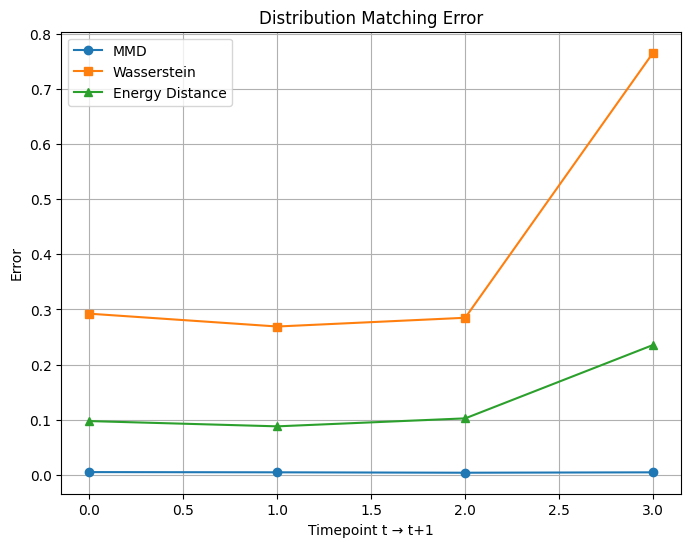

In [21]:
def compute_mmd_multi_rbf(X, Y, gammas=[2, 1, 0.5, 0.1, 0.01, 0.005]):
    """
    Compute multi-kernel MMD^2 between X and Y with multiple RBF gammas.

    X: [N, D]
    Y: [M, D]
    gammas: list of gamma values (1 / (2*sigma^2))

    Returns:
    mean MMD^2 across gammas
    """
    XX = torch.cdist(X, X, p=2)**2
    YY = torch.cdist(Y, Y, p=2)**2
    XY = torch.cdist(X, Y, p=2)**2

    m = X.size(0)
    n = Y.size(0)

    mmd_total = 0.0

    for gamma in gammas:
        K_XX = torch.exp(-gamma * XX)
        K_YY = torch.exp(-gamma * YY)
        K_XY = torch.exp(-gamma * XY)

        mmd2 = (K_XX.sum() - torch.diagonal(K_XX).sum()) / (m * (m - 1)) \
             + (K_YY.sum() - torch.diagonal(K_YY).sum()) / (n * (n - 1)) \
             - 2 * K_XY.mean()

        mmd_total += mmd2

    mean_mmd = mmd_total / len(gammas)
    return mean_mmd.item()

def compute_wasserstein(X, Y):
    # flatten to 1D for each feature or mean across features
    X_flat = X.cpu().numpy().flatten()
    Y_flat = Y.cpu().numpy().flatten()
    return wasserstein_distance(X_flat, Y_flat)

def compute_energy(X, Y):
    X_flat = X.cpu().numpy().flatten()
    Y_flat = Y.cpu().numpy().flatten()
    return energy_distance(X_flat, Y_flat)

def compute_r2(X, Y):
    X_flat = X.cpu().numpy().flatten()
    Y_flat = Y.cpu().numpy().flatten()
    return r2_score(Y_flat, X_flat)


def evaluate(node, X_input, device, steps=400, n_points=5000, plot_distributions=False):
    mmd_list = []
    wasserstein_list = []
    energy_list = []
    r2_list = []

    for t in range(len(X_input) - 1):
        print(f"Evaluating: time {t} → {t+1}")
        
        x0_np = X_input[t]
        x1_np = X_input[t + 1]

        n = min(n_points, min(len(x0_np), len(x1_np)))
        idx = np.random.choice(min(len(x0_np), len(x1_np)), size=n, replace=False)

        x0 = torch.tensor(x0_np[idx]).float().to(device)
        x1_true = torch.tensor(x1_np[idx]).float().to(device)

        t_span = torch.linspace(0, 1, steps).to(device)
        with torch.no_grad():
            traj = node.trajectory(x0, t_span)
        x1_pred = traj[-1]

        mmd_value = compute_mmd_multi_rbf(x1_pred.cpu(), x1_true.cpu())
        wasserstein_value = compute_wasserstein(x1_pred, x1_true)
        energy_value = compute_energy(x1_pred, x1_true)
        r2_value = compute_r2(x1_pred, x1_true)

        mmd_list.append(mmd_value)
        wasserstein_list.append(wasserstein_value)
        energy_list.append(energy_value)
        r2_list.append(r2_value)

        print (f"t={t} → t+1: MMD={mmd_value:.4f}, Wasserstein={wasserstein_value:.4f}, "
               f"Energy={energy_value:.4f}, R2={r2_value:.4f}")

        if plot_distributions:
            plt.figure(figsize=(6,4))
            sns.kdeplot(x1_pred.cpu().numpy().flatten(), label="Predicted", fill=True)
            sns.kdeplot(x1_true.cpu().numpy().flatten(), label="True", fill=True)
            plt.title(f"Distribution at t={t+1}")
            plt.xlabel("Feature value (flattened)")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return mmd_list, wasserstein_list, energy_list, r2_list

mmd_list, wassersten_list, energy_list, r2_list = evaluate(node, X_input, device)

plt.figure(figsize=(8,6))
plt.plot(range(len(mmd_list)), mmd_list, label='MMD', marker='o')
plt.plot(range(len(wassersten_list)), wassersten_list, label='Wasserstein', marker='s')
plt.plot(range(len(energy_list)), energy_list, label='Energy Distance', marker='^')
#plt.plot(range(len(r2_list)), r2_list, label='R2 Score', marker='D')
plt.xlabel("Timepoint t → t+1")
plt.ylabel("Error")
plt.title("Distribution Matching Error")
plt.legend()
plt.grid(True)
plt.show()